# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [27]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0
    Uninstalling pip-23.0:
      Successfully uninstalled pip-23.0


In [28]:
!pip install scikit-learn==1.2.1

In [29]:
!pip install p_tqdm --quiet
!pip install transformers --quiet
!pip install comet_ml --quiet
!pip install gensim --quiet
!pip install scikit-multilearn --quiet
!pip install liac-arff --quiet
!pip install keras --quiet
!pip install tensorflow --quiet
!pip install scikit-learn --upgrade --quiet
!pip install nlpaug --quiet
!pip install contractions --quiet
!pip install pytorch-pretrained-bert --quiet
!pip install nltk --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install sqlalchemy --quiet

In [32]:
import sklearn
print(sklearn.__version__)

1.2.1


In [4]:
# import libraries
import os
import ast
import numpy as np
import pandas as pd
import nltk
import string
import contractions
import itertools
import random
import sklearn
import gensim
print(sklearn.__version__)
import matplotlib.pyplot as plt
import seaborn as sb
import multiprocessing as mp
%matplotlib inline

from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.util import ngrams


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('universal_tagset')


from comet_ml import Experiment
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, classification_report, jaccard_score
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from skmultilearn.adapt import MLkNN
# from skmultilearn.ext import download_meka, Meka
from sklearn.neighbors import NearestNeighbors
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin

1.2.1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [6]:
COMET_API_KEY = "TkfogaXqILmxF0ShTe3LkgJFN"
COMET_PROJECT_NAME = "disaster_response_pipeline"
COMET_WORKSPACE = "benjtlv"
COMET_ARTIFACT = "disaster-response-data"

In [35]:
# load data from database
# engine = create_engine('sqlite:///DisasterResponse.db')
# df = pd.read_sql('SELECT * FROM DisasterResponse', con=engine)
# X = 
# Y = 

I prefer working with a Comet Artifact. If tomorrow we want to switch to a data lake, or a data warehouse, the mechanism will be the same.

In [36]:
def create_experiment():
    return Experiment(api_key=COMET_API_KEY, project_name=COMET_PROJECT_NAME, workspace=COMET_WORKSPACE)

In [19]:
experiment = create_experiment()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/benjtlv/disaster-response-pipeline/e8886536fdc742cf877692111bbef615



In [20]:
experiment = create_experiment()
experiment.add_tags(['training', 'bigram'])
artifact = experiment.get_artifact(COMET_ARTIFACT, version_or_alias='5.0.0', workspace=COMET_WORKSPACE)
artifact.download('./artifacts', overwrite_strategy='PRESERVE')

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/benjtlv/disaster-response-pipeline/e8886536fdc742cf877692111bbef615
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: Couldn't find a Git repository in '/root/Benjamin/DisasterResponse' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configur

Artifact(name='disaster-response-data', artifact_type='dataset', version=None, aliases=set(), version_tags=set())

To avoid Data Leakage, we will take our data of when before we started our EDA. We will remove bad words from our training data set so the model can learn what to give importance too, without being biased by high frequency unrelated words. We want to leave the test set untouched to see how the model behaves with unseen data.

In [7]:
# df = pd.read_csv('./artifacts/disaster_preprocessed.csv')
# df['message'] = df['message'].apply(ast.literal_eval)
df = pd.read_csv('disaster_transformed.csv')

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df = df.drop(df[df['related'] == 2].index)
df = df.drop('child_alone', axis=1)

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [10]:
print(df_train.shape[0])
print(df_test.shape[0])

20945
5237


### 2. Build Models

There are different algorithms that can be used in order for our ml model to handle multiple labels:
1. Binary Relevance
2. Label Powerset
3. MLkNN
4. Classifier Chain
5. Multioutput Classifier

We will not try label powerset as it only learns to predict a N-sized vector of 0 & 1s representing the assignment ot a label inside the N possible labels. It will not predict a vector that is different from those seens in the training dataset.

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

We will try multiple ML algorithms, with multiple algorithms for multi-label classification, with multiple ways of processing our text. We will see which models generalize well.

In [11]:
category_colnames = ['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 
                     'search_and_rescue', 'security', 'military', 'water', 'food', 'shelter', 
                     'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 
                     'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 
                     'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 
                     'other_weather', 'direct_report']

In [12]:
# df_train['message'] = df_train['message'].apply(lambda x: ' '.join([word for word in x]))
# df_test['message'] = df_test['message'].apply(lambda x: ' '.join([word for word in x]))

In [13]:
y_train = df_train.loc[:, category_colnames]
y_test = df_test.loc[:, category_colnames]

In [14]:
df_train.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
17668,20578,Previous experience has shown that the benefic...,NaN,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9461,10565,i would like to know in what number can i get ...,mwen ta renmen kon nen ki nimewo ke mwen ka an...,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11737,13448,RT otay: CNN Breaking News -- Tsunami warning ...,NaN,social,1,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
25131,28845,"* 16 debris clearing equipment, 3 recovery veh...",NaN,news,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14356,16930,"Under the approved plan, reconstruction in the...",NaN,news,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0


In [15]:
def classification_metrics(y_test, y_pred):
    print("Accuracy = ",accuracy_score(y_test ,y_pred))
    print("f1 score (micro) = ",f1_score(y_test, y_pred, average="micro"))
    print("f1 score (macro) = ",f1_score(y_test, y_pred, average="micro"))
    print("jaccard similarity = ", jaccard_score(y_test, y_pred, average="samples"))
    print("Hamming loss = ", hamming_loss(y_test,y_pred))

In [16]:
stop_words = stopwords.words('english')

In [13]:
def simple_pipeline(ngram_range=(1,1), model=LogisticRegression, tokenizer=None, stop_words=None):
    return Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer(tokenizer=tokenizer, stop_words=stop_words, ngram_range=ngram_range)),
        ('model', MultiOutputClassifier(model()))
    ])

Tfidf Vectorizer - single terms - Logistic regression

In [48]:
df_train['message']

23334    As the desert spreads, thousands of families o...
3368     they want to find some information on what is ...
17926    After-shocks continue to shake the area, and s...
18624    Once the male heads of the families started to...
24334    Since the mutiny, the whereabouts of Colonel Y...
                               ...                        
728      There is no food distribution in the area wher...
8506     The project of construction's center support 9...
4410     We sent a request for PAM food distribution. W...
21363    The impact of water on all aspects of developm...
20962    The United States has worked to strengthen dem...
Name: message, Length: 20945, dtype: object

In [23]:
pipeline = simple_pipeline()
pipeline.fit(df_train['message'], y_train)
classification_metrics(y_test, pipeline.predict(df_test['message']))

Accuracy =  0.2789765132709566
f1 score (micro) =  0.6536689876807713
f1 score (macro) =  0.6536689876807713
Hamming loss =  0.052914700346436076


Tfidf Vectorizer - single terms + bigrams - Logistic regression

In [33]:
pipeline = simple_pipeline(ngram_range=(1, 2))
pipeline.fit(df_train['message'], y_train)
classification_metrics(y_test, pipeline.predict(df_test['message']))

Accuracy =  0.2480427725797212
f1 score (micro) =  0.6382017638201765
f1 score (macro) =  0.6382017638201765
Hamming loss =  0.055058785018685726


Tfidf Vectorizer - single terms + bigrams + trigrams - Logistic regression

In [34]:
pipeline = simple_pipeline(ngram_range=(1, 3))
pipeline.fit(df_train['message'], y_train)
classification_metrics(y_test, pipeline.predict(df_test['message']))

Accuracy =  0.2245560435363758
f1 score (micro) =  0.6341118188251946
f1 score (macro) =  0.6341118188251946
Hamming loss =  0.05641179519354047


Tfidf Vectorizer - single terms + bigrams + trigrams - SVM with Linear kernel

In [35]:
pipeline = simple_pipeline(ngram_range=(1, 3), model=LinearSVC)
pipeline.fit(df_train['message'], y_train)
classification_metrics(y_test, pipeline.predict(df_test['message']))

Accuracy =  0.28031315638724463
f1 score (micro) =  0.6952227243382828
f1 score (macro) =  0.6952227243382828
Hamming loss =  0.05151258899588096


Tfidf Vectorizer - single terms + bigrams + trigrams - Random Forest

In [37]:
# pipeline = simple_pipeline(ngram_range=(1, 3), model=RandomForestClassifier)
# pipeline.fit(df_train['message'], y_train)
# classification_metrics(y_test, pipeline.predict(df_test['message']))

It seems like LinearSVC give us the best results here. Let's see if doing some preprocessing on our text improves the model

In [17]:
english_stop_words = stopwords.words('english')
disaster_stop_words = ['http', 'co', '000', 'bit', 'ly', 'u']
stop_words = list(itertools.chain(english_stop_words, disaster_stop_words))

In [39]:
def tokenize(text):
    text = ' '.join([contractions.fix(word) for word in text.split()])
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
        
    return clean_tokens

In [40]:
pipeline = simple_pipeline(tokenizer=tokenize, stop_words=stop_words, ngram_range=(1,3), model=LinearSVC)
pipeline.fit(df_train['message'], y_train)
classification_metrics(y_test, pipeline.predict(df_test['message']))

/usr/local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'shall', 'wa', 'would'] not in stop_words.
  warnings.warn(


Accuracy =  0.28565972885239643
f1 score (micro) =  0.6973097714412165
f1 score (macro) =  0.6973097714412165
Hamming loss =  0.052238195259008705


We have some improvements! Let's try to use POS tags to see how things improve

In [41]:
def tokenize_pos(tokens):
    pos_tags = nltk.pos_tag(tokens, tagset='universal')
    return [token+"_POS-"+tag for token, tag in pos_tags]

In [42]:
# pipeline = Pipeline([
#     ('tfidf_vectorizer', TfidfVectorizer(preprocessor=lambda x: x, tokenizer=tokenize_pos)),
#     ('model', MultiOutputClassifier(LinearSVC()))
# ])
# pipeline.fit(df_train['message'], y_train)
# classification_metrics(y_test, pipeline.predict(df_test['message']))

It took an eternity to run and it made things worse. Let's try to use POS tag another way.

In [18]:
def classification_report_dataframe(y_test, y_pred, i, col):
    classification_report_dict = classification_report(y_test[:, i], 
                                                       y_pred[:, i], 
                                                       target_names=[f'is not {col}', f'is {col}'], 
                                                       output_dict=True)
    return pd.DataFrame.from_dict(classification_report_dict).transpose().iloc[:2, :]

Let's reexecute our algorithm on the full dataset

In [28]:
pipeline = simple_pipeline(ngram_range=(1, 3), model=LinearSVC)
pipeline.fit(df_train['message'], y_train)
classification_metrics(y_test, pipeline.predict(df_test['message']))

Accuracy =  0.2860416268856215
f1 score (micro) =  0.7003074931218644
f1 score (macro) =  0.7003074931218644
Hamming loss =  0.05051419842330669


In [29]:
%%capture --no-display

y_pred = pipeline.predict(df_test['message'])
y_test = np.array(y_test)

df_reports = []
for i, col in enumerate(category_colnames):
    df_reports.append(classification_report_dataframe(y_test, y_pred, i, col))
report_df = pd.concat(df_reports)
report_df[~report_df.index.str.startswith('is not')].sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
is related,0.851159,0.947186,0.896608,4033.0
is earthquake,0.868735,0.774468,0.818898,470.0
is food,0.779264,0.796581,0.787828,585.0
is weather_related,0.767378,0.774844,0.771093,1439.0
is water,0.744253,0.770833,0.757310,336.0
is aid_related,0.699126,0.795568,0.744235,2211.0
is request,0.761307,0.673333,0.714623,900.0
is storm,0.753425,0.653465,0.699894,505.0
is shelter,0.808023,0.591195,0.682809,477.0
is floods,0.832765,0.571429,0.677778,427.0


Our data set is highly imbalanced. Certain classes are not representative at all. Because of this problem, our classifier tends to be weighed down by majority of classes and ignores the small ones. There are several approaches to handle this issue such as data level approach and algorithm level approach. 
The data level approach consists in balancing the class distribution through sampling, while the algorithm level approach is about adjusting weight or cost of various classes. The latter is better in terms of avoiding overfitting.

Because our Data is unbalanced, we can try to apply some over sampling data techniques.
Let's apply some Text Augmentation techniques. Let's apply some EDA (Easy Data Augmentation) techniques.

First, we can plot our label distribution

In [51]:
def plot_label_distributions(df_labels):
    plt.figure(figsize=(5, 7))

    title = 'labels_distribution'
    base_color = sb.color_palette()[0]
    class_counts = df_labels.sum().sort_values(ascending=False).to_frame().reset_index()
    class_counts.columns = ['labels', 'count']
    bar_plot = sb.barplot(data=class_counts, y='labels', x='count', color=base_color)
    plt.title(title);

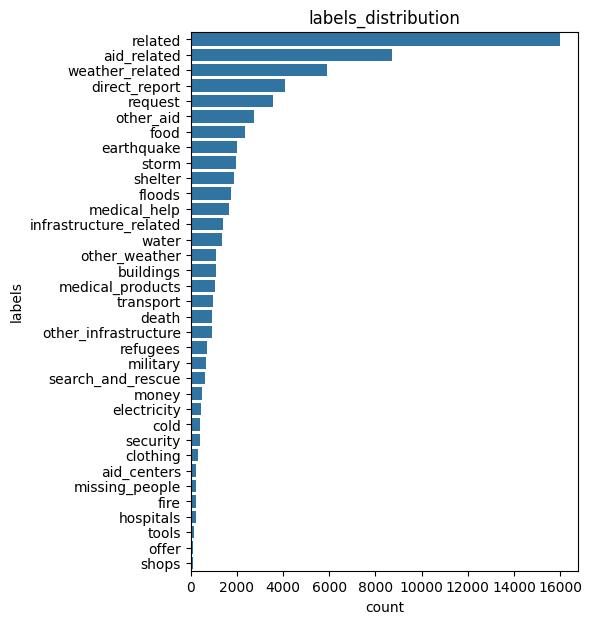

In [25]:
plot_label_distributions(y_train)

In [26]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action
from nlpaug.util.file.download import DownloadUtil
# DownloadUtil.download_glove(model_name='glove.6B', dest_dir='./content')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
text = 'climate change puts the squeeze on olives production'

Initialize our Word Augmentation Objects

In [28]:
bert_aug_sub = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", stopwords=stop_words, aug_p=.1)

bert_aug_insert = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", stopwords=stop_words, aug_p=.1)

syn_aug = naw.SynonymAug()

antonym_aug = naw.AntonymAug()

random_swap_aug = naw.random.RandomWordAug(action='swap', stopwords=stop_words, aug_p=.1)

random_delete_aug = naw.random.RandomWordAug(action='delete', stopwords=stop_words, aug_p=.1)

In [44]:
# sentence = 'climate change puts the squeeze on wine production'
# aug = naw.random.RandomWordAug(action='swap', aug_p=0.3)
# augmented_text = aug.augment(text, n=1)
# print('Original text :', text)
# print('Augmented text :', augmented_text)

Because we're in a multi-label setting, we want to identify the real misrepresented samples. There are possiblities that samples which contain minority labels can also contain majority labels. We will use a mix of techniques from the MLSMOTE paper combined with Text Data Augmentation. It's going to be fun!

Let's write a function which calculate the imbalance ratio

In [29]:
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

In [30]:
def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

In [35]:
df_train_minority, _ = get_minority_samples(df_train, y_train, ql=[0.25, 0.75])

In [36]:
df_train_minority.shape

(4050, 39)

Now we know exactly which samples we need to augment. We need to decide what percent of words to be altered in a sentence, but also the number of augmented sentences per sample. Let's call the first alpha, and the second Naug. According to the litterature, when having more than 5000 data points, the best performance has been obtained wiht alpha=0.1, and Naug=4.

Regarding the operations that we will be performing, we will opt for a mix of Synonym Replacement, Random Insertion, Random Swap & Random Deletion. All fours have shown to work equally well.

In [32]:
row = df_train_minority.iloc[[1]]
augmented_df = pd.concat([row]*8).reset_index(drop=True)
row_indexer = augmented_df.iloc[0:2].index
augmented_df.loc[row_indexer, 'message'] = ['a', 'b']
augmented_df.loc[row_indexer, :]

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,7527,a,On a jamais recu aucune aide sur le plan inter...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,7527,b,On a jamais recu aucune aide sur le plan inter...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
def process_data_point(i, df_minority, n_aug, augmentations, n_aug_per_method):
    message = df_minority.iloc[i]['message']

    copy_row = df_minority.iloc[[i]]
    augmented_sub_df = pd.concat([copy_row] * n_aug).reset_index(drop=True)

    slice_idx = 0
    for aug in augmentations:
        row_indexer = augmented_sub_df.iloc[slice_idx:slice_idx+n_aug_per_method].index
        augmented_sub_df.loc[row_indexer, 'message'] = aug.augment(message, n=n_aug_per_method)
        slice_idx += n_aug_per_method

    return augmented_sub_df

In [39]:
from p_tqdm import p_map
import math

def augment_minority_samples(df_minority, alpha=0.1, n_aug=4, augmentations=[bert_aug_sub, bert_aug_insert, random_swap_aug, random_delete_aug]):
    n_aug_per_method = math.ceil(len(augmentations) // n_aug)
    for i in range(len(augmentations)):
        augmentations[i].aug_p = alpha
    
    aug_df_l = []
#     aug_df_l = p_map(process_data_point, [(i, df_minority, n_aug, augmentations, n_aug_per_method) for i in range(df_minority.shape[0])], **{'num_cpus': 8})
    for i in tqdm(range(df_minority.shape[0])):
        aug_df_l.append(process_data_point(i, df_minority, n_aug, augmentations, n_aug_per_method))
    
    return pd.concat(aug_df_l).reset_index(drop=True)

In [40]:
os.environ['TOKENIZERS_PARALLELISM'] = 'True'
df_minority_augmented = augment_minority_samples(df_train_minority, augmentations=[syn_aug, antonym_aug, random_swap_aug, random_delete_aug])

100%|██████████| 4050/4050 [00:34<00:00, 116.78it/s]


In [42]:
df_train_augmented = pd.concat([df_train, df_minority_augmented]).reset_index(drop=True)
y_train_augmented = df_train_augmented.loc[:, category_colnames]

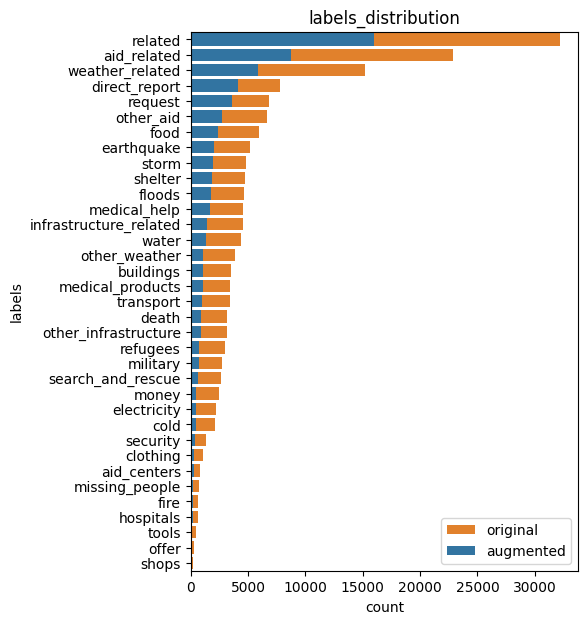

In [51]:
plt.figure(figsize=(5, 7))

title = 'labels_distribution'
class_counts = y_train.sum().sort_values(ascending=False).to_frame().reset_index()
class_counts_aug = y_train_augmented.sum().sort_values(ascending=False).to_frame().reset_index()
class_counts.columns = ['labels', 'count']
class_counts_aug.columns = ['labels', 'count']
sb.barplot(data=class_counts_aug, y='labels', x='count', color=sb.color_palette()[1], label='original')
sb.barplot(data=class_counts, y='labels', x='count', color=sb.color_palette()[0], label='augmented')
plt.legend()
plt.title(title);

Our data is still imbalanced, but we have more data for each label. Let's see if it improves our results

In [52]:
pipeline = simple_pipeline(ngram_range=(1, 3), model=LinearSVC)
pipeline.fit(df_train_augmented['message'], y_train_augmented)
classification_metrics(y_test, pipeline.predict(df_test['message']))

Accuracy =  0.2581630704601871
f1 score (micro) =  0.708805686622955
f1 score (macro) =  0.708805686622955
Hamming loss =  0.05185084153959464


Let's put related and request aside and train a model only for the rest of the categories, as most messages are most likely to be related or be a request

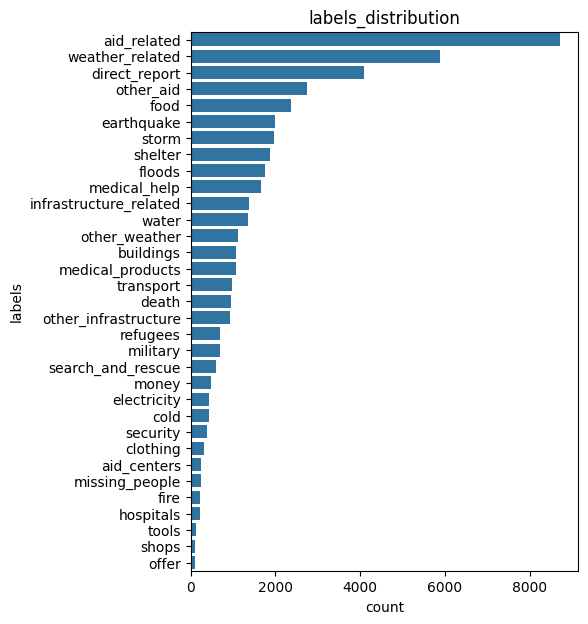

In [68]:
df_train_other_classes = df_train.drop(['related', 'request'], axis=1)
y_train_other_classes = y_train.iloc[:, 2:]
y_test_other_classes = y_test[:, 2:]
plot_label_distributions(y_train_other_classes)

Let's train a model for this data

In [69]:
pipeline = simple_pipeline(ngram_range=(1, 3), model=LinearSVC)
pipeline.fit(df_train_other_classes['message'], y_train_other_classes)
classification_metrics(y_test_other_classes, pipeline.predict(df_test['message']))

Accuracy =  0.4038571701355738
f1 score (micro) =  0.6313153205220825
f1 score (macro) =  0.6313153205220825
Hamming loss =  0.04429438552027821


In [72]:
other_classes = category_colnames[2:]

In [73]:
%%capture --no-display

y_pred = pipeline.predict(df_test['message'])

df_reports = []
for i, col in enumerate(other_classes):
    df_reports.append(classification_report_dataframe(y_test_other_classes, y_pred, i, col))
report_df = pd.concat(df_reports)
report_df[~report_df.index.str.startswith('is not')].sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
is earthquake,0.869359,0.783726,0.824324,467.0
is food,0.814433,0.797980,0.806122,594.0
is weather_related,0.778933,0.777855,0.778393,1445.0
is aid_related,0.698929,0.815261,0.752626,2241.0
is water,0.733333,0.711765,0.722388,340.0
is floods,0.871186,0.614833,0.720898,418.0
is storm,0.735808,0.666008,0.699170,506.0
is shelter,0.756684,0.603412,0.671412,469.0
is direct_report,0.687432,0.613659,0.648454,1025.0
is death,0.786207,0.440154,0.564356,259.0


Let's apply data augmentation only for those classes. Since we eliminated related and request, this should rebalance the data.

In [74]:
df_train_minority, _ = get_minority_samples(df_train_other_classes, y_train_other_classes)

In [77]:
df_minority_augmented = augment_minority_samples(df_train_minority, augmentations=[syn_aug, antonym_aug, random_swap_aug, random_delete_aug])

100%|██████████| 4780/4780 [00:41<00:00, 115.98it/s]


In [78]:
df_train_augmented = pd.concat([df_train_other_classes, df_minority_augmented]).reset_index(drop=True)
y_train_augmented = df_train_augmented.loc[:, other_classes]

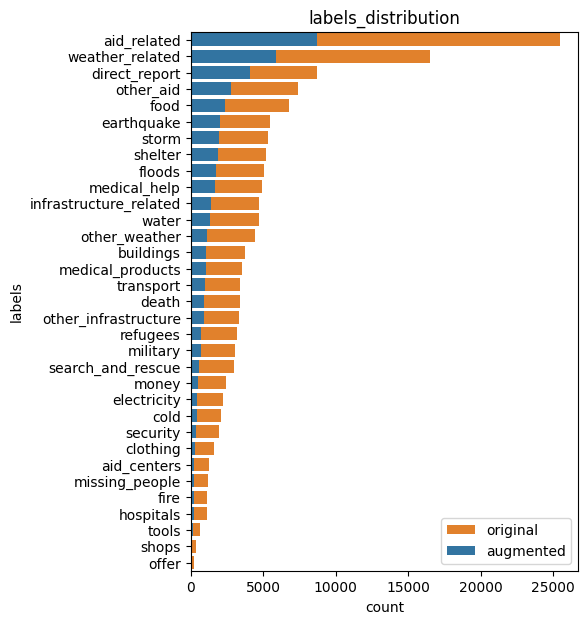

In [79]:
plt.figure(figsize=(5, 7))

title = 'labels_distribution'
class_counts = y_train_other_classes.sum().sort_values(ascending=False).to_frame().reset_index()
class_counts_aug = y_train_augmented.sum().sort_values(ascending=False).to_frame().reset_index()
class_counts.columns = ['labels', 'count']
class_counts_aug.columns = ['labels', 'count']
sb.barplot(data=class_counts_aug, y='labels', x='count', color=sb.color_palette()[1], label='original')
sb.barplot(data=class_counts, y='labels', x='count', color=sb.color_palette()[0], label='augmented')
plt.legend()
plt.title(title);

In [26]:
pipeline = simple_pipeline(ngram_range=(1, 3), model=LinearSVC)
pipeline.fit(df_train_augmented['message'], y_train_augmented)
classification_metrics(y_test_other_classes, pipeline.predict(df_test['message']))

NameError: name 'df_train_augmented' is not defined

This simple data augmentation technique didn't seem to help a lot. Maybe we should try using algorithms which assign different weights according to labels. We will use the scikit-multilearn library to test multiple techniques which can take into account the long tail classes distribution

## SCIKIT-MULTILEARN

Let's rerun our baseline model

In [52]:
pipeline = simple_pipeline(stop_words=stop_words, ngram_range=(1, 3), model=LinearSVC)
pipeline.fit(df_train['message'], y_train)
classification_metrics(y_test, pipeline.predict(df_test['message']))

Accuracy =  0.2887149131181974
f1 score (micro) =  0.7108576414859137
f1 score (macro) =  0.7108576414859137
jaccard similarity =  0.460120243006297
Hamming loss =  0.05061785646089637


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of unique label combination

In [53]:
np.unique(y_train, axis=0).shape

(3401, 35)

As we can see, we have arround 3400 different label combinations. This means that algorithms like ... , ... , ... will not perform well or take too much time to train

Labels coocurence matrix

In [19]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(np.array(y_train))

In [20]:
n_classes = len(category_colnames)
coocurence_matrix = np.zeros((n_classes, n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        p_i_j = np.sum((y_train[category_colnames[i]] == 1) & (y_train[category_colnames[j]] == 1)) / np.sum(y_train[category_colnames[i]] == 1)
        coocurence_matrix[i, j] = p_i_j

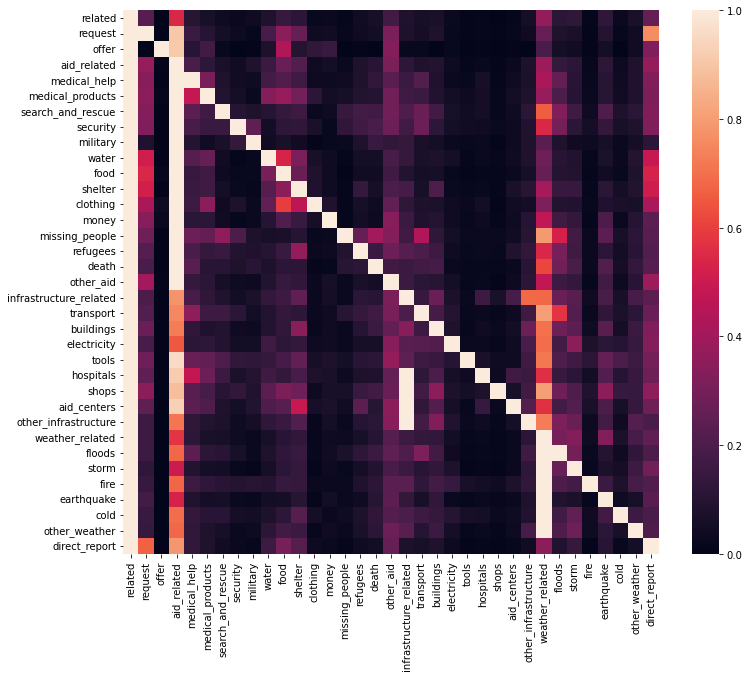

In [21]:
plt.figure(figsize=(12, 10))
sb.heatmap(data=coocurence_matrix, xticklabels=category_colnames, yticklabels=category_colnames);

This heatmap represents the probabilities p(i|j) i.e. the probability of an instance containing the label i under the condition of containing label j. 
For example we can see that when the probabilities of having labels like storm, floods, cold, fire, earthquake are very high when we also have label weather_related in the instance.
Also, when we have label infrastructure related, the probabilities of hospitals, shops, aid_centers are high.
A model taking account label cooccurences might give better results

#### Stochastic Block Model

In [20]:
# !conda create --name gt -c conda-forge graph-tool -y

In [21]:
# !conda init bash

In [22]:
# !conda activate gt

In [23]:
# from skmultilearn.cluster.graphtool import GraphToolLabelGraphClusterer, StochasticBlockModel

In [23]:
pipeline =  Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))),
    ('model', MultiOutputClassifier(LinearSVC(verbose=1)))
])
pipeline.fit(df_train['message'], y_train)
classification_metrics(y_test, pipeline.predict(df_test['message']))

[LibLinear]....*
optimization finished, #iter = 45
Objective value = -3988.099446
nSV = 17309
[LibLinear]....*
optimization finished, #iter = 44
Objective value = -2561.728811
nSV = 16319
[LibLinear]....*
optimization finished, #iter = 42
Objective value = -129.558083
nSV = 5346
[LibLinear]....*
optimization finished, #iter = 46
Objective value = -5080.794252
nSV = 19629
[LibLinear]....*
optimization finished, #iter = 42
Objective value = -1762.497491
nSV = 15961
[LibLinear]....*
optimization finished, #iter = 42
Objective value = -1137.524865
nSV = 13226
[LibLinear]....*
optimization finished, #iter = 41
Objective value = -728.161397
nSV = 12789
[LibLinear]...*.
optimization finished, #iter = 40
Objective value = -535.963410
nSV = 12324
[LibLinear]....*
optimization finished, #iter = 43
Objective value = -730.179689
nSV = 11305
[LibLinear]...*
optimization finished, #iter = 38
Objective value = -945.159130
nSV = 9984
[LibLinear]...*
optimization finished, #iter = 39
Objective value = 

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pipeline =  Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))),
    ('model', BinaryRelevance(LinearSVC(verbose=1)))
])
pipeline.fit(df_train['message'], y_train.iloc[:, :2])
classification_metrics(y_test.iloc[:, :2], pipeline.predict(df_test['message']))

In [24]:
from skmultilearn.dataset import load_dataset

X_train, y_train, feature_names, label_names = load_dataset('emotions', 'train')
X_test, y_test, _, _ =load_dataset('emotions', 'test')

from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=3)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

emotions:train - exists, not redownloading
emotions:test - exists, not redownloading


TypeError: __init__() takes 1 positional argument but 2 were given

In [ ]:
# pipeline =  Pipeline([
#     ('tfidf_vectorizer', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))),
#     ('model', ClassifierChain(LinearSVC(verbose=1), verbose=True))
# ])
# pipeline.fit(df_train['message'], y_train)
# classification_metrics(y_test, pipeline.predict(df_test['message']))

In [3]:
# from scipy.sparse import csr_matrix, lil_matrix

# pipeline =  Pipeline([
#     ('tfidf_vectorizer', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))),
#     ('model', MLkNN(k=3))
# ])
# X_train = lil_matrix(df_train['message']).toarray()
# y_tain = lil_matrix(y_train).toarray()
# pipeline.fit(X_train, y_tain)

# X_test = lil_matrix(df_test['message']).toarray()
# classification_metrics(y_test, pipeline.predict(X_test))

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.